::: {.callout-note title="Colab Link"}

<center>

[![](images/colab-badge.svg)<br>Click here to **open in Colab**](https://colab.research.google.com/drive/1D53LJxDkRYedqqM-twlww6Lwaspv4gf0){target="_blank"}

</center>

:::

# Decision Trees for Musical Genre Classification

What musical characteristics distinguish Hip Hop songs from Jazz songs? EDM songs from Ambient songs?

Arguments over these types of questions can occupy fans of music (especially chronically-overthinking ones like myself) for hours at a time, but in this lab we'll take a different approach: as a step towards **adjudicating** these arguments, we'll ask a **computer** to discover the relationship between individual songs and their genres, from two different perspectives represented by two different questions we can ask:

* **Question 1**: Which features of a song are **most predictive** of the song's genre?
* **Question 2**: What line(s) could we draw to **segment** the space of all songs into subspaces representing Jazz, Hip Hop, etc.? For example, are there particular ranges of **tempo**, **song duration**, or **loudness** which most Jazz songs adopt?

While **Question 1** represents a task you could already approach using methods we've learned in class to this point (specifically, the *Feature Selction* methods we've discussed), **Question 2** is a new kind of task: a task for which **Decision Trees** (**DTs**) are particularly helpful!

The reason DTs are so helpful for answering **Question 2** is that, while other methods like **Naïve Bayes** or **Neural Networks** can usually achieve greater accuracy on classification tasks than DTs (and can be more helpful for answering **Question 1** specifically), DTs answer **both** of our questions simultaneously: given a feature matrix $\mathbf{X}$ and a label vector $\mathbf{y}$, they tell us

1. **Which features** in $\mathbf{X}$ are most important for predicting the labels in $\mathbf{y}$, but also
2. Precisely where we should **"cut" the feature values in $\mathbf{X}$** if we want to split the feature space into regions which distinguish (say) points with **positive** labels from points with **negative** labels

In last week's slides, for example, I introduced a scenario where we found ourselves dropped somewhere on the planet at some time of year, and we wanted to know whether or this place and time had **good skiing**, on the basis of the following dataset:

![](https://jjacobs.me/dsan5000/463a01339cf0f456ba54a1849df50d1a22c247e3/w12/index_files/figure-revealjs/ski-plot-binary-1.png)

For this data, while methods we already know like Naïve Bayes or Support Vector Machines may be able to **classify the points with high accuracy**, these methods do **not** give us an interpretable set of **decision boundaries**, telling us how we could "chop" this Month-Latitude space up into sub-regions to separate good-skiing regions from bad-skiing regions[^svm].

[^svm]: The Support Vector Machine algorithm comes close, but this method learns a **separating hyperplane** between the two classes, i.e., a "line" in some high-dimensional space, which is therefore less easily-interpretable than the 1-dimensional cutpoints that DTs learn.]

In other words, what we lose in terms of the **efficiency** or **accuracy** of DTs relative to other algorithms, we gain in terms of **interpretability**: while a Support Vector Machine approach may find that computing the value

$$
f_i^* = \frac{\text{Tempo}_i^7 + \pi \cdot \sqrt{\text{SongDuration}_i}}{\lceil e^{\text{Danceability}_i} + \sqrt{2}\rceil !}
$$

is extremely predictive of the genre of a song, this does not help us much as humans in terms of **understanding** what it is in a song that distinguishes its genre.

DTs help us here, therefore, in that they are **restricted** to learning **trees** which are determined solely by a collection of pairs $(f,s)$, where $f$ is a feature and $s$ is a cutpoint, at each level of the tree. Thus, continuing the song-classification example, a one-level DT would only be allowed to learn a single rule $(f,s)$, which would be interpretable as:

> If you can only make a single "cut" in the feature space, you should cut it into a subregion $R_1$ containing all points $X_i$ for which feature $f$ is less than $s$ ($X_{i,f} < s$), and a subregion $R_2$ containing all points where feature $f$ is greater than $s$ ($X_{i,f} \geq s$)

So that, using the particular features we have for songs, this could translate to:

> The single feature which is most predictive of a song's genre is $\text{Tempo}$: if a song's tempo is greater than 120bpm, you should classify it as EDM, while if the song's tempo is less than 120bpm you should classify it as Jazz.

## (1) Data Scraping

For the actual dataset, we're going to use Spotify's Web API, which is very cool in general but specifically cool because it allows us to access a bunch of <a href='https://developer.spotify.com/documentation/web-api/reference/get-audio-features' target='_blank'>Spotify-generated **"audio features"**</a> for each track, consisting of the following information about the track:

| Feature | Description |
| - | - |
| `acousticness` | A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. |
| `danceability` | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| `duration_ms` | The duration of the track in milliseconds. |
| `energy` | Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| `instrumentalness` | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| `key` | The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. |
| `liveness` | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| `loudness` | The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db. |
| `mode` | Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. |
| `speechiness` | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| `tempo` | The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. |
| `time_signature` | An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". |
| `valence` | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |

Here we need Spotify API keys, which we load:

* (In Colab) using Colab's new Secrets functionality (accessible in the sidebar on the left, by clicking the key icon, above the folder icon)
* (Otherwise) using a `.env` file in the base directory of our project (which we make sure to **not** commit to GitHub!)

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  from google.colab import userdata
  client_id = userdata.get('SPOTIFY_CLIENT_ID')
  secret_id = userdata.get('SPOTIFY_SECRET_ID')
  redirect_url = userdata.get('SPOTIFY_REDIRECT_URL')
else:
  import dotenv
  import os
  dotenv.load_dotenv(override=True)
  client_id = os.getenv('SPOTIFY_CLIENT_ID')
  secret_id = os.getenv('SPOTIFY_CLIENT_SECRET')
  redirect_uri = os.getenv('SPOTIFY_REDIRECT_URI')

In [2]:
import requests
import pandas as pd
import numpy as np

Here we create a **session**, since we're going to want to send an authorization header with every request we make to the Spotify API. Using a session object allows us to set the headers just once, rather than having to provide a `headers` argument to every `requests` call.

In [3]:
my_session = requests.session()

Here we request an **access token**, which we will be able to use to make calls to the Spotify API for one hour (at which point we'll have to request another access token, by re-running this code)

In [4]:
token_request_url = "https://accounts.spotify.com/api/token"
tr_headers = {
    'Content-Type': 'application/x-www-form-urlencoded'
}
tr_data = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': secret_id
}
response = my_session.post(token_request_url, headers=tr_headers, data=tr_data)

In [5]:
response_json = response.json()
my_token = response_json['access_token']
my_token

'BQBsa7MAbWkvRPWDgJlpS6N8uqzFiIpI25AX0DPTrg6jRMblq3GDZ7rSzab6DLt-7EDdhcb4KwiKwBUAQLD_HqmHy7QKvsJBu3LddB1Ky2QL19YP9hg'

Now we can include this access token in our session's header settings, so that from now on all calls to the Spotify API will include this token as our authorization:

In [6]:
session_header = {
    'Authorization': f'Bearer {my_token}'
}
my_session.headers.update(session_header)

In [7]:
genre_map = {
    # https://musicalyst.com/genre/jazz
    'Jazz': [
        'Chet Baker', 'Ella Fitzgerald', 'Stan Getz', 'Billie Holiday',
        'Miles Davis', 'John Coltrane', 'Bill Evans', 'Duke Ellington',
        'Herbie Hancock', 'Bill Evans Trio', 'Charles Mingus', 'Wes Montgomery'
    ],
    'Hip Hop': [
        'Drake', 'Kanye West', 'Kendrick Lamar', 'Tyler, The Creator',
        'Metro Boomin', 'Travis Scott', 'Mac Miller', 'J. Cole',
        'Eminem', 'Lil Uzi Vert', '21 Savage', 'Future'
    ],
    'Rock': [
        'Arctic Monkeys', 'Radiohead', 'Deftones', 'Tame Impala',
        'The Smiths', 'Nirvana', 'Queen', 'The Beatles',
        'Paramore', 'The 1975', 'Gorillaz', 'My Chemical Romance'
    ],
    'EDM': [
        'Calvin Harris', 'David Guetta', 'Avicii', 'Fred again..',
        'Tiësto', 'Marshmello', 'Skrillex', 'Kygo',
        'ILLENIUM', 'Martin Garrix', 'Flume', 'Zedd'
    ],
    'R&B': [
        'SZA', 'Beyoncé', 'Brent Faiyaz', 'Michael Jackson',
        'Summer Walker', 'Tory Lanez', 'Bryson Tiller', 'PARTYNEXTDOOR',
        'Chris Brown', 'Miguel', 'Giveon', 'Jhené Aiko'
    ],
    'Country': [
        'Luke Combs', 'Luke Bryan', 'Zac Brown Band', 'Jason Aldean',
        'Jon Pardi', 'Thomas Rhett', 'Florida Georgia Line', 'Kenny Chesney',
        'Carrie Underwood', 'George Strait', 'Kelsea Ballerini', 'Sam Hunt'
    ],
    'Ambient': [
        'Aphex Twin', 'Grouper', 'Brian Eno', 'Tim Hecker',
        'Oneohtrix Point Never', 'Harold Budd', 'William Basinski', 'Chihei Hatakeyama',
        'Hiroshi Yoshimura', 'Marconi Union', 'Susumu Yokota', 'Stars Of The Lid'
    ]
}

In [8]:
data_rows = []
for cur_genre, artist_list in genre_map.items():
    for cur_artist in artist_list:
        cur_data = {
            'artist': cur_artist,
            'genre': cur_genre
        }
        data_rows.append(cur_data)
artist_df = pd.DataFrame(data_rows)
artist_df

,artist,genre
0,Chet Baker,Jazz
1,Ella Fitzgerald,Jazz
2,Stan Getz,Jazz
3,Billie Holiday,Jazz
4,Miles Davis,Jazz
...,...,...
79,Chihei Hatakeyama,Ambient
80,Hiroshi Yoshimura,Ambient
81,Marconi Union,Ambient
82,Susumu Yokota,Ambient


In [9]:
# Get spotify id for each artist
artist_search_template = "https://api.spotify.com/v1/search?q={query}&type=artist"
def get_artist_id(artist_name):
    artist_search_url = artist_search_template.format(query=artist_name)
    artist_search_response = my_session.get(artist_search_url)
    artist_response_json = artist_search_response.json()
    response_artists = artist_response_json['artists']
    #response_artists.keys()
    artist_id = response_artists['items'][0]['id']
    return artist_id
artist_df['artist_id'] = artist_df['artist'].apply(get_artist_id)

And save this information to a `.csv` file, so we don't have to make redundant API calls:

In [10]:
artist_df.to_csv("artist_ids.csv", index=False)

In [11]:
artist_df.head()

,artist,genre,artist_id
0,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T
1,Ella Fitzgerald,Jazz,5V0MlUE1Bft0mbLlND7FJz
2,Stan Getz,Jazz,0FMucZsEnCxs5pqBjHjIc8
3,Billie Holiday,Jazz,1YzCsTRb22dQkh9lghPIrp
4,Miles Davis,Jazz,0kbYTNQb4Pb1rPbbaF0pT4


Now we can request the most popular songs for each artist. To see how this works, first we request the most popular songs for the first artist in our DataFrame, Chet Baker:

In [12]:
first_artist_id = artist_df.iloc[0]['artist_id']
artist_api_template = 'https://api.spotify.com/v1/artists/{artist_id}/top-tracks?market=US'
artist_api_url = artist_api_template.format(artist_id = first_artist_id)
response = my_session.get(artist_api_url)
response_json = response.json()

In [13]:
response_tracks = response_json['tracks']
len(response_tracks)

10

In [14]:
response_tracks

[{'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3rxeQlsv0Sc2nyYaZ5W71T'},
     'href': 'https://api.spotify.com/v1/artists/3rxeQlsv0Sc2nyYaZ5W71T',
     'id': '3rxeQlsv0Sc2nyYaZ5W71T',
     'name': 'Chet Baker',
     'type': 'artist',
     'uri': 'spotify:artist:3rxeQlsv0Sc2nyYaZ5W71T'}],
   'external_urls': {'spotify': 'https://open.spotify.com/album/5JJ779nrbHx0KB2lBrMMa4'},
   'href': 'https://api.spotify.com/v1/albums/5JJ779nrbHx0KB2lBrMMa4',
   'id': '5JJ779nrbHx0KB2lBrMMa4',
   'images': [{'height': 640,
     'url': 'https://i.scdn.co/image/ab67616d0000b273bcaf6f097b310e20504f2de0',
     'width': 640},
    {'height': 300,
     'url': 'https://i.scdn.co/image/ab67616d00001e02bcaf6f097b310e20504f2de0',
     'width': 300},
    {'height': 64,
     'url': 'https://i.scdn.co/image/ab67616d00004851bcaf6f097b310e20504f2de0',
     'width': 64}],
   'is_playable': True,
   'name': 'Chet Baker Sings',
   'release_date': '1956'

In [15]:
track_ids = [track_data['id'] for track_data in response_tracks]
track_ids_str = ','.join(track_ids)
track_ids_str

'0F845nujLVqCb0XMZCh5Pc,4l9hml2UCnxoNI3yCdL1BW,4m6OC8u2rC6LMFtFWsME7d,1QlTNF43OyKK9BorIRsJ8o,4gFlHAye7To29Fs4UszQUH,06UkYE0SZ3Y8zGRFOuWGAe,3pfbQmD5xGH9Tcc7GqGfSL,2d64G7VaZdHQuAquz5HQNu,00jqmEUSISjkugkuFxGiTo,0UZFhlhUMrYyzzyOHkylM3'

And now we can get the **features** for these tracks:

In [16]:
aud_feature_template = 'https://api.spotify.com/v1/audio-features?ids={track_ids}'
aud_feature_url = aud_feature_template.format(track_ids = track_ids_str)
aud_feature_response = my_session.get(aud_feature_url)
aud_feat_list = aud_feature_response.json()['audio_features']

For each track, we now have feature info, so we add each track's info to a list, which we then convert to a DataFrame

In [17]:
aud_feat_list[1]

{'danceability': 0.438,
 'energy': 0.00756,
 'key': 0,
 'loudness': -26.44,
 'mode': 0,
 'speechiness': 0.0382,
 'acousticness': 0.941,
 'instrumentalness': 0.00643,
 'liveness': 0.109,
 'valence': 0.277,
 'tempo': 133.32,
 'type': 'audio_features',
 'id': '4l9hml2UCnxoNI3yCdL1BW',
 'uri': 'spotify:track:4l9hml2UCnxoNI3yCdL1BW',
 'track_href': 'https://api.spotify.com/v1/tracks/4l9hml2UCnxoNI3yCdL1BW',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4l9hml2UCnxoNI3yCdL1BW',
 'duration_ms': 141133,
 'time_signature': 4}

In [18]:
artist_df[artist_df['artist'] == "Tory Lanez"]

,artist,genre,artist_id
53,Tory Lanez,R&B,2jku7tDXc6XoB6MO2hFuqg


Now we can do this in a loop, for **all** of the artists!

In [19]:
all_track_data = []
for row_index, row in artist_df.iterrows():
  cur_artist = row['artist']
  print(cur_artist)
  cur_genre = row['genre']
  cur_artist_id = row['artist_id']
  # Get the artist's top songs
  artist_api_url = artist_api_template.format(artist_id = cur_artist_id)
  artist_response = my_session.get(artist_api_url)
  artist_response_json = artist_response.json()
  print(artist_response_json.keys())
  artist_response_tracks = artist_response_json['tracks']
  track_names = [track_data['name'] for track_data in artist_response_tracks]
  track_ids = [track_data['id'] for track_data in artist_response_tracks]
  track_ids_str = ','.join(track_ids)
  # Now we query the audio features API with this list of tracks
  aud_feature_url = aud_feature_template.format(track_ids = track_ids_str)
  aud_feature_response = my_session.get(aud_feature_url)
  if 'audio_features' not in aud_feature_response.json():
    continue
  aud_feat_list = aud_feature_response.json()['audio_features']
  # Each entry in aud_feat_list contains info for the track, so we create a dict
  # object for each entry, and add each one to all_track_data
  for track_index, cur_aud_feats in enumerate(aud_feat_list):
    if cur_aud_feats is None:
      continue
    cur_track_data = {
        'artist': cur_artist,
        'genre': cur_genre,
        'artist_id': cur_artist_id,
        'name': track_names[track_index]
    }
    cur_track_data.update(cur_aud_feats)
    all_track_data.append(cur_track_data)

Chet Baker
dict_keys(['tracks'])


Ella Fitzgerald
dict_keys(['tracks'])


Stan Getz
dict_keys(['tracks'])


Billie Holiday
dict_keys(['tracks'])


Miles Davis


dict_keys(['tracks'])
John Coltrane


dict_keys(['tracks'])


Bill Evans
dict_keys(['tracks'])


Duke Ellington
dict_keys(['tracks'])


Herbie Hancock
dict_keys(['tracks'])


Bill Evans Trio


dict_keys(['tracks'])
Charles Mingus


dict_keys(['tracks'])
Wes Montgomery


dict_keys(['tracks'])
Drake


dict_keys(['tracks'])


Kanye West


dict_keys(['tracks'])
Kendrick Lamar


dict_keys(['tracks'])


Tyler, The Creator
dict_keys(['tracks'])


Metro Boomin


dict_keys(['tracks'])
Travis Scott


dict_keys(['tracks'])
Mac Miller


dict_keys(['tracks'])


J. Cole


dict_keys(['tracks'])
Eminem


dict_keys(['tracks'])
Lil Uzi Vert


dict_keys(['tracks'])


21 Savage
dict_keys(['tracks'])


Future
dict_keys(['tracks'])


Arctic Monkeys


dict_keys(['tracks'])
Radiohead


dict_keys(['tracks'])
Deftones


dict_keys(['tracks'])
Tame Impala


dict_keys(['tracks'])


The Smiths
dict_keys(['tracks'])


Nirvana
dict_keys(['tracks'])


Queen
dict_keys(['tracks'])


The Beatles
dict_keys(['tracks'])


Paramore
dict_keys(['tracks'])


The 1975


dict_keys(['tracks'])


Gorillaz


dict_keys(['tracks'])
My Chemical Romance


dict_keys(['tracks'])
Calvin Harris


dict_keys(['tracks'])
David Guetta


dict_keys(['tracks'])


Avicii


dict_keys(['tracks'])


Fred again..


dict_keys(['tracks'])


Tiësto
dict_keys(['tracks'])


Marshmello


dict_keys(['tracks'])
Skrillex


dict_keys(['tracks'])
Kygo


dict_keys(['tracks'])
ILLENIUM


dict_keys(['tracks'])
Martin Garrix


dict_keys(['tracks'])
Flume


dict_keys(['tracks'])
Zedd


dict_keys(['tracks'])
SZA


dict_keys(['tracks'])
Beyoncé


dict_keys(['tracks'])


Brent Faiyaz
dict_keys(['tracks'])


Michael Jackson


dict_keys(['tracks'])
Summer Walker


dict_keys(['tracks'])


Tory Lanez


dict_keys(['tracks'])


Bryson Tiller


dict_keys(['tracks'])
PARTYNEXTDOOR


dict_keys(['tracks'])
Chris Brown


dict_keys(['tracks'])
Miguel


dict_keys(['tracks'])
Giveon


dict_keys(['tracks'])


Jhené Aiko


dict_keys(['tracks'])
Luke Combs


dict_keys(['tracks'])
Luke Bryan


dict_keys(['tracks'])
Zac Brown Band


dict_keys(['tracks'])
Jason Aldean


dict_keys(['tracks'])
Jon Pardi


dict_keys(['tracks'])
Thomas Rhett


dict_keys(['tracks'])
Florida Georgia Line


dict_keys(['tracks'])
Kenny Chesney


dict_keys(['tracks'])
Carrie Underwood


dict_keys(['tracks'])
George Strait


dict_keys(['tracks'])
Kelsea Ballerini


dict_keys(['tracks'])
Sam Hunt


dict_keys(['tracks'])


Aphex Twin


dict_keys(['tracks'])
Grouper


dict_keys(['tracks'])
Brian Eno


dict_keys(['tracks'])
Tim Hecker


dict_keys(['tracks'])
Oneohtrix Point Never


dict_keys(['tracks'])


Harold Budd
dict_keys(['tracks'])


William Basinski
dict_keys(['tracks'])


Chihei Hatakeyama


dict_keys(['tracks'])
Hiroshi Yoshimura


dict_keys(['tracks'])
Marconi Union


dict_keys(['tracks'])


Susumu Yokota
dict_keys(['tracks'])


Stars Of The Lid
dict_keys(['tracks'])


In [20]:
track_df = pd.DataFrame(all_track_data)
track_df.head()

,artist,genre,artist_id,name,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T,I Fall In Love Too Easily,0.532,0.06570,0,-19.136,0,0.0406,...,0.0946,0.292,128.607,audio_features,0F845nujLVqCb0XMZCh5Pc,spotify:track:0F845nujLVqCb0XMZCh5Pc,https://api.spotify.com/v1/tracks/0F845nujLVqC...,https://api.spotify.com/v1/audio-analysis/0F84...,201440,4
1,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T,My Funny Valentine,0.438,0.00756,0,-26.440,0,0.0382,...,0.1090,0.277,133.320,audio_features,4l9hml2UCnxoNI3yCdL1BW,spotify:track:4l9hml2UCnxoNI3yCdL1BW,https://api.spotify.com/v1/tracks/4l9hml2UCnxo...,https://api.spotify.com/v1/audio-analysis/4l9h...,141133,4
2,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T,Time After Time - Vocal Version,0.501,0.04540,0,-18.783,1,0.0388,...,0.2000,0.255,99.783,audio_features,4m6OC8u2rC6LMFtFWsME7d,spotify:track:4m6OC8u2rC6LMFtFWsME7d,https://api.spotify.com/v1/tracks/4m6OC8u2rC6L...,https://api.spotify.com/v1/audio-analysis/4m6O...,166760,4
3,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T,Autumn Leaves,0.350,0.60700,5,-11.141,0,0.0498,...,0.1160,0.597,187.101,audio_features,1QlTNF43OyKK9BorIRsJ8o,spotify:track:1QlTNF43OyKK9BorIRsJ8o,https://api.spotify.com/v1/tracks/1QlTNF43OyKK...,https://api.spotify.com/v1/audio-analysis/1QlT...,422640,4
4,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T,I Get Along Without You Very Well (Except Some...,0.442,0.03300,10,-23.063,1,0.0410,...,0.1510,0.210,103.340,audio_features,4gFlHAye7To29Fs4UszQUH,spotify:track:4gFlHAye7To29Fs4UszQUH,https://api.spotify.com/v1/tracks/4gFlHAye7To2...,https://api.spotify.com/v1/audio-analysis/4gFl...,179640,3


In [21]:
track_df.to_csv("track_features.csv", index=False)

## (2) Decision Tree

In [22]:
# Comment out the following lines if you modified the above code, to use your own
# artists/genres/features. Otherwise, this loads a pre-scraped dataset
track_features_url = "https://jpj.georgetown.domains/dsan5000-scratch/dt/track_features.csv"
track_df = pd.read_csv(track_features_url)

In [23]:
track_df.head()

,artist,genre,artist_id,name,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T,I Fall In Love Too Easily,0.532,0.06570,0,-19.136,0,0.0406,...,0.0946,0.292,128.607,audio_features,0F845nujLVqCb0XMZCh5Pc,spotify:track:0F845nujLVqCb0XMZCh5Pc,https://api.spotify.com/v1/tracks/0F845nujLVqC...,https://api.spotify.com/v1/audio-analysis/0F84...,201440,4
1,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T,My Funny Valentine,0.438,0.00756,0,-26.440,0,0.0382,...,0.1090,0.277,133.320,audio_features,4l9hml2UCnxoNI3yCdL1BW,spotify:track:4l9hml2UCnxoNI3yCdL1BW,https://api.spotify.com/v1/tracks/4l9hml2UCnxo...,https://api.spotify.com/v1/audio-analysis/4l9h...,141133,4
2,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T,Time After Time - Vocal Version,0.501,0.04540,0,-18.783,1,0.0388,...,0.2000,0.255,99.783,audio_features,4m6OC8u2rC6LMFtFWsME7d,spotify:track:4m6OC8u2rC6LMFtFWsME7d,https://api.spotify.com/v1/tracks/4m6OC8u2rC6L...,https://api.spotify.com/v1/audio-analysis/4m6O...,166760,4
3,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T,Autumn Leaves,0.350,0.60700,5,-11.141,0,0.0498,...,0.1160,0.597,187.101,audio_features,1QlTNF43OyKK9BorIRsJ8o,spotify:track:1QlTNF43OyKK9BorIRsJ8o,https://api.spotify.com/v1/tracks/1QlTNF43OyKK...,https://api.spotify.com/v1/audio-analysis/1QlT...,422640,4
4,Chet Baker,Jazz,3rxeQlsv0Sc2nyYaZ5W71T,I Get Along Without You Very Well (Except Some...,0.442,0.03300,10,-23.063,1,0.0410,...,0.1510,0.210,103.340,audio_features,4gFlHAye7To29Fs4UszQUH,spotify:track:4gFlHAye7To29Fs4UszQUH,https://api.spotify.com/v1/tracks/4gFlHAye7To2...,https://api.spotify.com/v1/audio-analysis/4gFl...,179640,3


In [24]:
import sklearn.tree
import sklearn.model_selection

Exclude specific genres, if desired

In [25]:
exclude_genres = ['Rock', 'Country', 'R&B']
#exclude_genres = []
track_df_sub = track_df[~track_df['genre'].isin(exclude_genres)].copy()

Let's create **numeric** codes for our label variable (`genre`), by just assigning each genre a number representing its place in alphabetical order:

In [26]:
sorted_genres = sorted(list(track_df_sub['genre'].value_counts().index))
genre_map = {genre_name: sorted_genres.index(genre_name) for genre_name in sorted_genres}
genre_map

{'Ambient': 0, 'EDM': 1, 'Hip Hop': 2, 'Jazz': 3}

And now we can create `genre_code` as our numeric label variable

In [27]:
track_df_sub['genre_code'] = track_df_sub['genre'].apply(lambda x: genre_map[x])

Next let's specify the columns we want to include in our derived **feature matrix**

In [28]:
track_df_sub.columns

Index(['artist', 'genre', 'artist_id', 'name', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 'genre_code'],
      dtype='object')

Quick thing: so that we can take its log, we make a new feature "quietness" which is just the negative of loudness (since loudness is measured in dB)

In [29]:
if 'log_loudness' not in track_df_sub.columns:
  track_df_sub['quietness'] = track_df_sub['loudness'].apply(lambda x: -x)
  # And now we drop loudness
  track_df_sub.drop(columns=['loudness'], inplace=True)
  track_df_sub['log_quiet'] = track_df_sub['quietness'].apply(np.log)
  # And now we drop quietness
  track_df_sub.drop(columns=['quietness'], inplace=True)
  # Finally, we can now "reconstruct" log_loud
  max_quiet = track_df_sub['log_quiet'].max()
  track_df_sub['log_loudness'] = track_df_sub['log_quiet'].apply(lambda x: max_quiet - x)
  # And drop log_quiet
  track_df_sub.drop(columns=['log_quiet'], inplace=True)

In [30]:
feature_cols = [
    'danceability', 'energy', 'key',
    #'loudness',
    'log_loudness',
    #'log_quiet',
    #'mode',
    #'speechiness',
    'acousticness',
    #'instrumentalness',
    'liveness', 'valence', 'tempo',
    'duration_ms', 'time_signature'
]
label_col = 'genre_code'
non_label_cols = [c for c in track_df_sub.columns if c != label_col]
# Here, just so that the train-test split is clean, we include *everything*,
# then split, then subset to only the numeric columns
X_df = track_df_sub[non_label_cols].copy()
y = track_df_sub[label_col]
# And perform train-test split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_df, y, test_size=0.2, random_state=5000
)
# And now we subset X_train and X_test to contain just the numeric features
X_train_num = X_train[feature_cols].copy()
X_test_num = X_test[feature_cols].copy()

In [31]:
X_train_num

,danceability,energy,key,log_loudness,acousticness,liveness,valence,tempo,duration_ms,time_signature
87,0.7390,0.8820,11,1.227378,0.1090,0.0185,0.9410,98.424,482720,4
52,0.3720,0.1870,0,1.105307,0.9420,0.1610,0.2170,70.334,319733,4
103,0.4880,0.4760,5,1.374079,0.4380,0.1100,0.5830,110.951,482960,4
377,0.6260,0.8640,8,2.569942,0.0682,0.0870,0.5550,123.833,161387,4
463,0.5440,0.5790,8,1.565358,0.1930,0.1170,0.2940,109.769,303661,4
...,...,...,...,...,...,...,...,...,...,...
773,0.2440,0.0621,9,0.774876,0.9930,0.1190,0.0358,65.540,62947,5
129,0.5610,0.5200,11,1.473254,0.0503,0.3550,0.4240,153.150,239360,3
97,0.6080,0.1580,5,0.747203,0.9000,0.0996,0.1460,120.055,211467,4
810,0.0746,0.1560,9,0.529429,0.8630,0.1050,0.0463,80.494,458907,5


In [32]:
X_train_num.shape

(383, 10)

In [33]:
y_train.head()

87     3
52     3
103    3
377    1
463    1
Name: genre_code, dtype: int64

In [34]:
y_train.shape

(383,)

In [35]:
dtc = sklearn.tree.DecisionTreeClassifier(
    max_depth = 2,
    random_state=5000,
    #min_samples_leaf=8,
    min_impurity_decrease=0.02
)
dtc.fit(X_train_num, y_train)

DecisionTreeClassifier(max_depth=2, min_impurity_decrease=0.02,
                       random_state=5000)

In [36]:
y_train_pred = dtc.predict(X_train_num)
y_test_pred = dtc.predict(X_test_num)

In [37]:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_train['prediction'] = y_train_pred
Xy_test = pd.concat([X_test, y_test], axis=1)
Xy_test['prediction'] = y_test_pred

In [38]:
genre_map.keys()

dict_keys(['Ambient', 'EDM', 'Hip Hop', 'Jazz'])

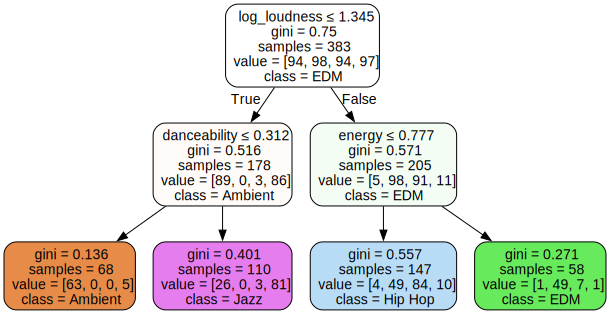

In [39]:
import graphviz
def visualize_tree(dtc_object):
  dot_data = sklearn.tree.export_graphviz(dtc_object, out_file=None,
                      feature_names=X_train_num.columns,
                      class_names=list(genre_map.keys()),
                      filled=True, rounded=True,
                      special_characters=True)
  graph = graphviz.Source(dot_data)
  graph.render(outfile="test.svg")
  return graph
visualize_tree(dtc)

Let's make an interactive plot visualizing these cutpoints, so that we can hover over the points to see what songs they represent!

In [40]:
import plotly.express as px
import plotly.graph_objs as go

In [41]:
track_fig = px.scatter(X_train, x='log_loudness', y='danceability', color='genre',
                       hover_data=['name','artist'], template='simple_white')
track_fig.update_layout(title_text='All Songs', title_x=0.5)
loudness_cutoff = 1.345
dance_cutoff = 0.312
energy_cutoff = 0.777
x0 = [loudness_cutoff, loudness_cutoff]
y0 = [0.0, 1.0]
track_fig.add_trace(go.Scatter(name='Decision Boundary',x=x0, y=y0))
track_fig.add_annotation(x=loudness_cutoff - 0.3, y=0,
            text="← Quiet Songs",
            showarrow=False,
            yshift=10)
track_fig.add_annotation(x=loudness_cutoff + 0.3, y=0,
            text="Loud Songs →",
            showarrow=False,
            yshift=10)
track_fig.show()

In [42]:
track_df_quiet = track_df_sub[track_df_sub['log_loudness'] <= loudness_cutoff].copy()
track_df_loud = track_df_sub[track_df_sub['log_loudness'] > loudness_cutoff].copy()

In [43]:
quiet_fig = px.scatter(track_df_quiet, x='log_loudness', y='danceability', color='genre',
                       hover_data=['name','artist'], template='simple_white')
quiet_fig.update_layout(title_text='Quiet Songs', title_x=0.5)
#fig.add_vrect(x0=0.9, x1=2)
x1 = [0, loudness_cutoff]
y1 = [dance_cutoff, dance_cutoff]
quiet_fig.add_trace(go.Scatter(name='Decision Boundary', x=x1, y=y1))
quiet_fig.add_annotation(x=0.3, y=dance_cutoff + 0.005,
            text="↑ Predict Jazz",
            showarrow=False,
            yshift=10)
quiet_fig.add_annotation(x=0.3, y=dance_cutoff - 0.05,
            text="↓ Predict Ambient",
            showarrow=False,
            yshift=10)
quiet_fig.show()

In [44]:
loud_fig = px.scatter(track_df_loud, x='log_loudness', y='energy', color='genre',
                       hover_data=['name','artist'], template='simple_white')
loud_fig.update_layout(title_text='Loud Songs', title_x=0.5)
x1 = [loudness_cutoff, track_df_loud['log_loudness'].max()]
y1 = [energy_cutoff, energy_cutoff]
loud_fig.add_trace(go.Scatter(name='Decision Boundary', x=x1, y=y1))
# track_fig.add_trace(go.Scatter(x=x1, y=y1))
#track_fig.add_trace(go.Scatter(x=x2, y=y2))
loud_fig.add_annotation(x=3.3, y=energy_cutoff + 0.01,
            text="↑ Predict EDM",
            showarrow=False,
            yshift=10)
loud_fig.add_annotation(x=3.3, y=energy_cutoff - 0.045,
            text="↓ Predict Hip Hop",
            showarrow=False,
            yshift=10)
loud_fig.show()

Now let's check accuracy

In [45]:
Xy_train = pd.concat([X_train,y_train], axis=1)
Xy_test = pd.concat([X_test,y_test], axis=1)
Xy_train['prediction'] = y_train_pred
Xy_test['prediction'] = y_test_pred

In [46]:
Xy_train['correct'] = Xy_train['prediction'] == Xy_train['genre_code']
Xy_test['correct'] = Xy_test['prediction'] == Xy_test['genre_code']

In [47]:
Xy_train['correct'].value_counts(normalize=True)

correct
True     0.723238
False    0.276762
Name: proportion, dtype: float64

In [48]:
Xy_test['correct'].value_counts(normalize=True)

correct
True     0.708333
False    0.291667
Name: proportion, dtype: float64

## (3) Random Forests

In [49]:
import sklearn.ensemble

Here we define a function that takes in a range of values for the `n_estimators` hyperparameter, and a range of values for the `max_depth` hyperparameter, and generates a DataFrame containing information on the training and test accuracies for a `RandomForestClassifier` trained using these values.

In [50]:
def accuracy_over_range(est_range, depth_range, long_format=True):
  result_data = []
  for cur_estimators in est_range:
    for cur_depth in depth_range:
      cur_rfc = sklearn.ensemble.RandomForestClassifier(
        n_estimators = cur_estimators,
        max_depth = cur_depth,
        random_state = 5000
      )
      cur_rfc.fit(X_train_num, y_train)
      y_train_pred_rfc = cur_rfc.predict(X_train_num)
      y_test_pred_rfc = cur_rfc.predict(X_test_num)
      y_train_correct = y_train_pred_rfc == Xy_train['genre_code']
      y_test_correct = y_test_pred_rfc == Xy_test['genre_code']
      train_accuracy = sum(y_train_correct) / len(y_train_correct)
      test_accuracy = sum(y_test_correct) / len(y_test_correct)
      cur_result = {
          'n_estimators': cur_estimators,
          'max_depth': cur_depth,
          'train_accuracy': train_accuracy,
          'test_accuracy': test_accuracy
      }
      result_data.append(cur_result)
  rfc_result_df = pd.DataFrame(result_data)
  if long_format:
    # Convert to long so we can plot train and test accuracies together
    rfc_long_df = pd.melt(rfc_result_df, id_vars=['n_estimators','max_depth'])
    return rfc_long_df
  return rfc_result_df

First, let's see what values we'd want to use if we were optimizing for **(test) accuracy**, by considering a wide range of possible values:

In [51]:
estimators_range = np.arange(20, 220, 20)
depth_range = [2,3,4,5,6,7]
rfc_result_df = accuracy_over_range(estimators_range, depth_range)

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

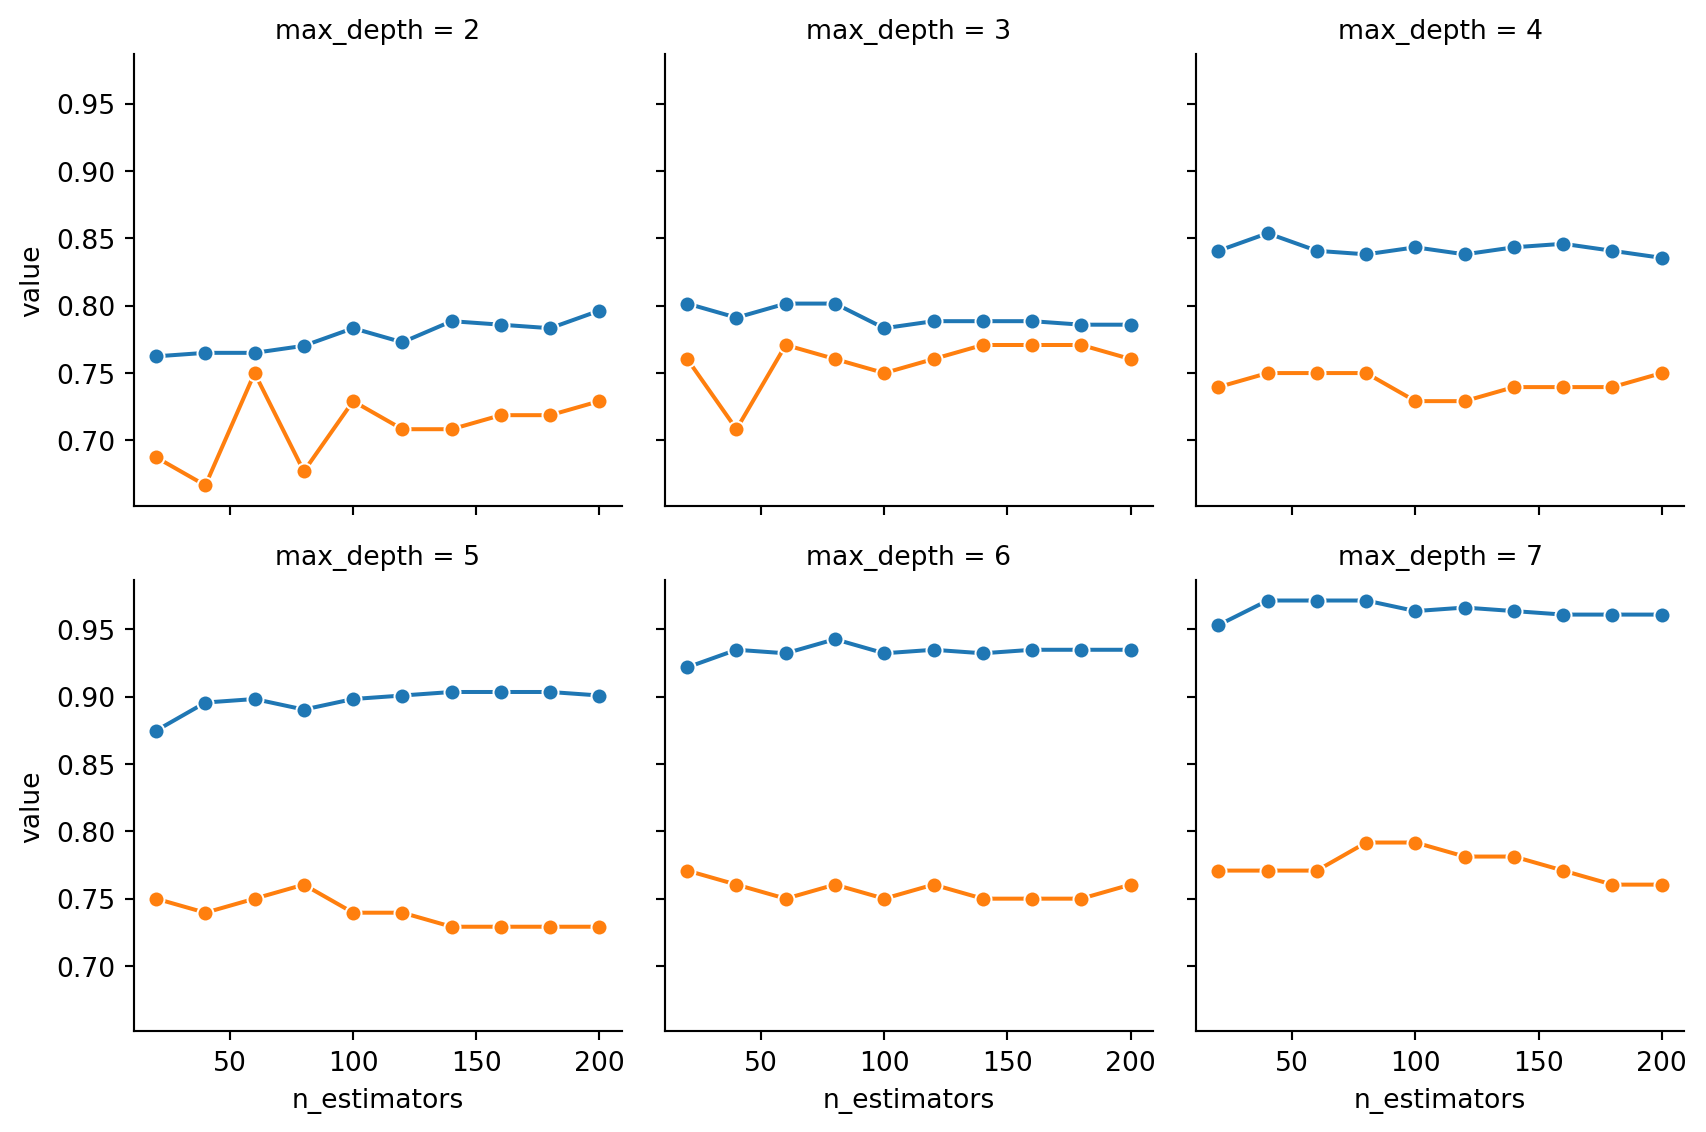

In [53]:
def plot_hyperparam_grid(result_df, wrap=3):
  g = sns.FacetGrid(result_df, col="max_depth", col_wrap=wrap)
  g.map_dataframe(sns.lineplot, x="n_estimators", y="value", hue='variable', marker='o')
  plt.show()
plot_hyperparam_grid(rfc_result_df)

From these plots we can see that, while we're always able to improve **training accuracy** by choosing higher values for `max_depth`, we're not able to obtain a **test accuracy** much higher than 0.75 or 0.80 no matter what parameter values we choose.

If our goal was solely to train a model with high accuracy, we might stop here and report our results (though, this would be a questionable choice, since as mentioned above you can almost always obtain higher accuracies using other ML algorithms like Neural Networks). Here, since we're focusing on **interpretability**, let's narrow our range of hyperparameters down to much smaller values, find an optimal RF within these ranges, and then actually **look at** the individual DTs which make up our optimal RF!

In [54]:
estimators_range = np.arange(3, 9, 2)
depth_range = [2,3,4,5]
rfc_result_df_small = accuracy_over_range(estimators_range, depth_range)

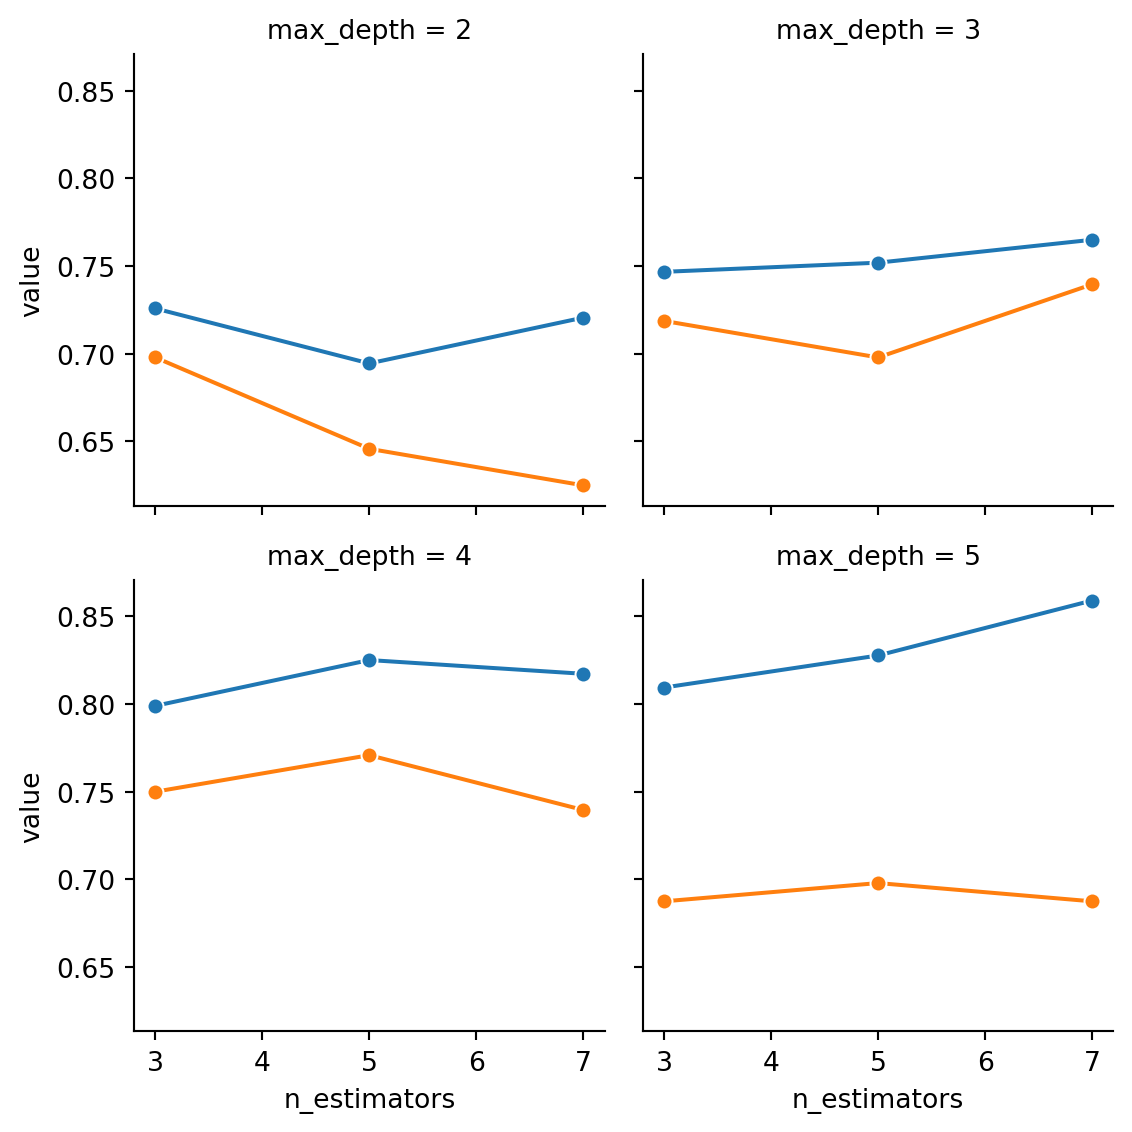

In [55]:
plot_hyperparam_grid(rfc_result_df_small, wrap=2)

In [56]:
# Choose the "best" estimator with max_depth == 2
is_depth_2 = rfc_result_df_small['max_depth'] == 2
is_test_acc = rfc_result_df_small['variable'] == "test_accuracy"
n2_test_df = rfc_result_df_small[is_depth_2 & is_test_acc].copy()
n2_test_df.loc[n2_test_df['value'].idxmax(),]

n_estimators                3
max_depth                   2
variable        test_accuracy
value                0.697917
Name: 12, dtype: object

In [57]:
# Train the "optimal" predictor
rfc_opt = sklearn.ensemble.RandomForestClassifier(
    n_estimators = 3,
    max_depth = 2,
    random_state = 5000
)

In [58]:
rfc_opt.fit(X_train_num, y_train)

RandomForestClassifier(max_depth=2, n_estimators=3, random_state=5000)

In [59]:
y_pred_train = rfc_opt.predict(X_train_num)
y_pred_test = rfc_opt.predict(X_test_num)

In [60]:
subtrees = rfc_opt.estimators_

In [61]:
vis_objects = [visualize_tree(cur_subtree) for cur_subtree in subtrees]
#vis_obj = visualize_tree(cur_subtree)
#print(type(vis_obj))
#display(vis_obj)
#from IPython.display import HTML

Subtree #1


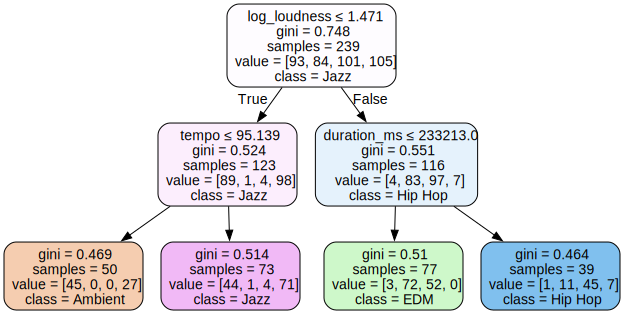

Subtree #2


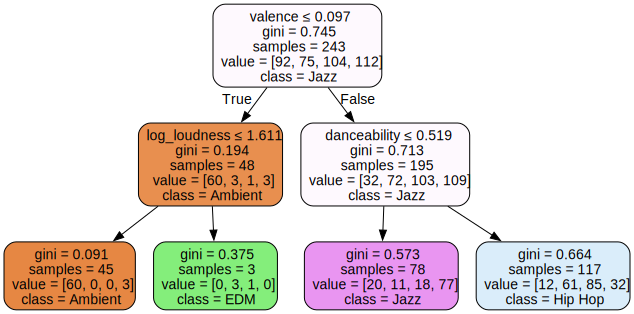

Subtree #3


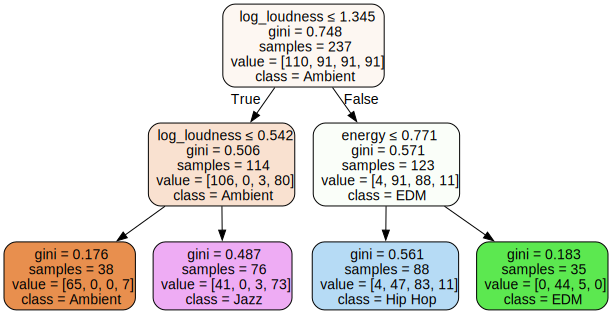

In [62]:
for vis_index, cur_vis in enumerate(vis_objects):
  print(f"Subtree #{vis_index + 1}")
  display(cur_vis)

And from these visualizations we can start to see, roughly, how a `RandomForestClassifier` (as an **ensemble** of multiple Decision Trees) could beat out a single `DecisionTreeClassifier`: just like how a pair of darts players where one player always hits slightly above the bullseye and the other player always hits slightly below the bullseye would "average out" to be a bullseye-every-time team, an ensemble of decision trees, each focusing on minimizing errors for a given **subset** of the full feature space, will "average out" to be more accurate than any individual tree could be. **Subtree #2** in this case, for example, finds that `valence` rather than `log_loudness` was the most important feature, with respect to the subset of the feature matrix that it was given.